In [64]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import confusion_matrix,accuracy_score

In [2]:
class DropoutNetwork(nn.Module):
    def __init__(self,input_dim,output_dim,proba_drop):
        #assign module after called Module.__init__() 
        super(DropoutNetwork, self).__init__()
        #basic parameters
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.proba_drop=proba_drop
        self.hidden_dim=int((input_dim+output_dim)/2)
        #construction of layers
        self.layer1=nn.Linear(input_dim,self.hidden_dim)
        self.layer2=nn.Linear(self.hidden_dim,self.hidden_dim)
        self.layer3=nn.Linear(self.hidden_dim,self.output_dim)
        #nn.init.normal_(self.layer1.weight)
        #nn.init.normal_(self.layer2.weight)
        #nn.init.normal_(self.layer3.weight)
        
    def forward(self, xdata,drop_inplace=False):
        #inplace=False means input vector will not be changed
        
        input=xdata.view(-1,self.input_dim)
        input=F.dropout(input,p=self.proba_drop,training=self.training,inplace=drop_inplace)
          
        #Pass layer 1
        input=self.layer1(input)
        #Remark: training = True may be change to self.training to compare pred MCdropout and pred naive.
        input=F.dropout(input,p=self.proba_drop,training=self.training,inplace=drop_inplace)
        input=F.relu(input)
        #Pass layer 2
        input=self.layer2(input)
        input=F.dropout(input,p=self.proba_drop,training=self.training,inplace=drop_inplace)
        input=F.relu(input)
        #Pass layer 3 to get the output
        output=self.layer3(input)
        
        return output

Parameters

In [3]:
batch_size=256
learning_rate=1e-3 #may be changed to adaptive rate
cuda=False
device = torch.device("cpu") #"cuda" if args.cuda else 
input_dim=28*28
nclasses=10
p_drop=0.5
n_epochs=50

In [4]:
model=DropoutNetwork(input_dim,nclasses,p_drop)

In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True,
                   transform=transforms.ToTensor()),
    batch_size=1, shuffle=True, **kwargs)

Processing...
Done!


In [12]:
def train(n_epochs=50,display_step=10,criterion = nn.CrossEntropyLoss()):
    model.train()
    
    for epoch in range(n_epochs):
        epoch_loss=0
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate/(epoch+1))
        
        for batch_idx, (xdata,ydata) in enumerate(train_loader):
            #if we have cuda
            xdata=xdata.to(device)
            ydata=ydata.to(device)

            optimizer.zero_grad()
            output=model(xdata)
            
            loss=criterion(output,ydata)
            epoch_loss+=loss.item()
            loss.backward()
            optimizer.step()
            
            if batch_idx % display_step==0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)] lr: {}\tLoss: {:.6f}'
                  .format(epoch+1, batch_idx * len(ydata),
                          len(train_loader.dataset),
                          100. * batch_idx / len(train_loader),
                          learning_rate/(epoch+1), loss.item()))
        print("Finish {} epoch(s). Epoch loss: {}.".format(epoch+1,epoch_loss/len(train_loader)))
        

In [13]:
train()

Train Epoch: 1 [0/60000 (0%)] lr: 0.001	Loss: 2.303787
Train Epoch: 1 [2560/60000 (4%)] lr: 0.001	Loss: 1.899794
Train Epoch: 1 [5120/60000 (9%)] lr: 0.001	Loss: 1.036946
Train Epoch: 1 [7680/60000 (13%)] lr: 0.001	Loss: 0.843606
Train Epoch: 1 [10240/60000 (17%)] lr: 0.001	Loss: 0.701042
Train Epoch: 1 [12800/60000 (21%)] lr: 0.001	Loss: 0.739169
Train Epoch: 1 [15360/60000 (26%)] lr: 0.001	Loss: 0.618845
Train Epoch: 1 [17920/60000 (30%)] lr: 0.001	Loss: 0.699894
Train Epoch: 1 [20480/60000 (34%)] lr: 0.001	Loss: 0.566059
Train Epoch: 1 [23040/60000 (38%)] lr: 0.001	Loss: 0.469241
Train Epoch: 1 [25600/60000 (43%)] lr: 0.001	Loss: 0.622306
Train Epoch: 1 [28160/60000 (47%)] lr: 0.001	Loss: 0.501206
Train Epoch: 1 [30720/60000 (51%)] lr: 0.001	Loss: 0.503086
Train Epoch: 1 [33280/60000 (55%)] lr: 0.001	Loss: 0.455076
Train Epoch: 1 [35840/60000 (60%)] lr: 0.001	Loss: 0.496750
Train Epoch: 1 [38400/60000 (64%)] lr: 0.001	Loss: 0.426650
Train Epoch: 1 [40960/60000 (68%)] lr: 0.001	Loss:

Train Epoch: 6 [12800/60000 (21%)] lr: 0.00016666666666666666	Loss: 0.237910
Train Epoch: 6 [15360/60000 (26%)] lr: 0.00016666666666666666	Loss: 0.200762
Train Epoch: 6 [17920/60000 (30%)] lr: 0.00016666666666666666	Loss: 0.223635
Train Epoch: 6 [20480/60000 (34%)] lr: 0.00016666666666666666	Loss: 0.215047
Train Epoch: 6 [23040/60000 (38%)] lr: 0.00016666666666666666	Loss: 0.270272
Train Epoch: 6 [25600/60000 (43%)] lr: 0.00016666666666666666	Loss: 0.255577
Train Epoch: 6 [28160/60000 (47%)] lr: 0.00016666666666666666	Loss: 0.298723
Train Epoch: 6 [30720/60000 (51%)] lr: 0.00016666666666666666	Loss: 0.206436
Train Epoch: 6 [33280/60000 (55%)] lr: 0.00016666666666666666	Loss: 0.253493
Train Epoch: 6 [35840/60000 (60%)] lr: 0.00016666666666666666	Loss: 0.235781
Train Epoch: 6 [38400/60000 (64%)] lr: 0.00016666666666666666	Loss: 0.166703
Train Epoch: 6 [40960/60000 (68%)] lr: 0.00016666666666666666	Loss: 0.177651
Train Epoch: 6 [43520/60000 (72%)] lr: 0.00016666666666666666	Loss: 0.210721

Train Epoch: 10 [56320/60000 (94%)] lr: 0.0001	Loss: 0.196260
Train Epoch: 10 [58880/60000 (98%)] lr: 0.0001	Loss: 0.143535
Finish 10 epoch(s). Epoch loss: 0.20880602100428114.
Train Epoch: 11 [0/60000 (0%)] lr: 9.090909090909092e-05	Loss: 0.195491
Train Epoch: 11 [2560/60000 (4%)] lr: 9.090909090909092e-05	Loss: 0.184680
Train Epoch: 11 [5120/60000 (9%)] lr: 9.090909090909092e-05	Loss: 0.243679
Train Epoch: 11 [7680/60000 (13%)] lr: 9.090909090909092e-05	Loss: 0.200317
Train Epoch: 11 [10240/60000 (17%)] lr: 9.090909090909092e-05	Loss: 0.289696
Train Epoch: 11 [12800/60000 (21%)] lr: 9.090909090909092e-05	Loss: 0.156441
Train Epoch: 11 [15360/60000 (26%)] lr: 9.090909090909092e-05	Loss: 0.160888
Train Epoch: 11 [17920/60000 (30%)] lr: 9.090909090909092e-05	Loss: 0.238549
Train Epoch: 11 [20480/60000 (34%)] lr: 9.090909090909092e-05	Loss: 0.154718
Train Epoch: 11 [23040/60000 (38%)] lr: 9.090909090909092e-05	Loss: 0.296370
Train Epoch: 11 [25600/60000 (43%)] lr: 9.090909090909092e-05	L

Train Epoch: 15 [17920/60000 (30%)] lr: 6.666666666666667e-05	Loss: 0.285183
Train Epoch: 15 [20480/60000 (34%)] lr: 6.666666666666667e-05	Loss: 0.175059
Train Epoch: 15 [23040/60000 (38%)] lr: 6.666666666666667e-05	Loss: 0.195563
Train Epoch: 15 [25600/60000 (43%)] lr: 6.666666666666667e-05	Loss: 0.147180
Train Epoch: 15 [28160/60000 (47%)] lr: 6.666666666666667e-05	Loss: 0.175025
Train Epoch: 15 [30720/60000 (51%)] lr: 6.666666666666667e-05	Loss: 0.194844
Train Epoch: 15 [33280/60000 (55%)] lr: 6.666666666666667e-05	Loss: 0.211051
Train Epoch: 15 [35840/60000 (60%)] lr: 6.666666666666667e-05	Loss: 0.191985
Train Epoch: 15 [38400/60000 (64%)] lr: 6.666666666666667e-05	Loss: 0.199691
Train Epoch: 15 [40960/60000 (68%)] lr: 6.666666666666667e-05	Loss: 0.156797
Train Epoch: 15 [43520/60000 (72%)] lr: 6.666666666666667e-05	Loss: 0.205101
Train Epoch: 15 [46080/60000 (77%)] lr: 6.666666666666667e-05	Loss: 0.165639
Train Epoch: 15 [48640/60000 (81%)] lr: 6.666666666666667e-05	Loss: 0.204617

Train Epoch: 19 [48640/60000 (81%)] lr: 5.2631578947368424e-05	Loss: 0.179967
Train Epoch: 19 [51200/60000 (85%)] lr: 5.2631578947368424e-05	Loss: 0.167302
Train Epoch: 19 [53760/60000 (89%)] lr: 5.2631578947368424e-05	Loss: 0.171770
Train Epoch: 19 [56320/60000 (94%)] lr: 5.2631578947368424e-05	Loss: 0.199555
Train Epoch: 19 [58880/60000 (98%)] lr: 5.2631578947368424e-05	Loss: 0.154495
Finish 19 epoch(s). Epoch loss: 0.18834407342241166.
Train Epoch: 20 [0/60000 (0%)] lr: 5e-05	Loss: 0.132422
Train Epoch: 20 [2560/60000 (4%)] lr: 5e-05	Loss: 0.198349
Train Epoch: 20 [5120/60000 (9%)] lr: 5e-05	Loss: 0.190815
Train Epoch: 20 [7680/60000 (13%)] lr: 5e-05	Loss: 0.177949
Train Epoch: 20 [10240/60000 (17%)] lr: 5e-05	Loss: 0.181395
Train Epoch: 20 [12800/60000 (21%)] lr: 5e-05	Loss: 0.240568
Train Epoch: 20 [15360/60000 (26%)] lr: 5e-05	Loss: 0.169774
Train Epoch: 20 [17920/60000 (30%)] lr: 5e-05	Loss: 0.191460
Train Epoch: 20 [20480/60000 (34%)] lr: 5e-05	Loss: 0.200626
Train Epoch: 20 [2

Train Epoch: 24 [20480/60000 (34%)] lr: 4.1666666666666665e-05	Loss: 0.216705
Train Epoch: 24 [23040/60000 (38%)] lr: 4.1666666666666665e-05	Loss: 0.142668
Train Epoch: 24 [25600/60000 (43%)] lr: 4.1666666666666665e-05	Loss: 0.210677
Train Epoch: 24 [28160/60000 (47%)] lr: 4.1666666666666665e-05	Loss: 0.175924
Train Epoch: 24 [30720/60000 (51%)] lr: 4.1666666666666665e-05	Loss: 0.179077
Train Epoch: 24 [33280/60000 (55%)] lr: 4.1666666666666665e-05	Loss: 0.160558
Train Epoch: 24 [35840/60000 (60%)] lr: 4.1666666666666665e-05	Loss: 0.170980
Train Epoch: 24 [38400/60000 (64%)] lr: 4.1666666666666665e-05	Loss: 0.200610
Train Epoch: 24 [40960/60000 (68%)] lr: 4.1666666666666665e-05	Loss: 0.118699
Train Epoch: 24 [43520/60000 (72%)] lr: 4.1666666666666665e-05	Loss: 0.155347
Train Epoch: 24 [46080/60000 (77%)] lr: 4.1666666666666665e-05	Loss: 0.234472
Train Epoch: 24 [48640/60000 (81%)] lr: 4.1666666666666665e-05	Loss: 0.161739
Train Epoch: 24 [51200/60000 (85%)] lr: 4.1666666666666665e-05	L

Train Epoch: 28 [53760/60000 (89%)] lr: 3.571428571428572e-05	Loss: 0.156629
Train Epoch: 28 [56320/60000 (94%)] lr: 3.571428571428572e-05	Loss: 0.286672
Train Epoch: 28 [58880/60000 (98%)] lr: 3.571428571428572e-05	Loss: 0.237636
Finish 28 epoch(s). Epoch loss: 0.17521285132524814.
Train Epoch: 29 [0/60000 (0%)] lr: 3.4482758620689657e-05	Loss: 0.138124
Train Epoch: 29 [2560/60000 (4%)] lr: 3.4482758620689657e-05	Loss: 0.207500
Train Epoch: 29 [5120/60000 (9%)] lr: 3.4482758620689657e-05	Loss: 0.194497
Train Epoch: 29 [7680/60000 (13%)] lr: 3.4482758620689657e-05	Loss: 0.159786
Train Epoch: 29 [10240/60000 (17%)] lr: 3.4482758620689657e-05	Loss: 0.159967
Train Epoch: 29 [12800/60000 (21%)] lr: 3.4482758620689657e-05	Loss: 0.163789
Train Epoch: 29 [15360/60000 (26%)] lr: 3.4482758620689657e-05	Loss: 0.183106
Train Epoch: 29 [17920/60000 (30%)] lr: 3.4482758620689657e-05	Loss: 0.187423
Train Epoch: 29 [20480/60000 (34%)] lr: 3.4482758620689657e-05	Loss: 0.114919
Train Epoch: 29 [23040/6

Train Epoch: 33 [20480/60000 (34%)] lr: 3.0303030303030302e-05	Loss: 0.136695
Train Epoch: 33 [23040/60000 (38%)] lr: 3.0303030303030302e-05	Loss: 0.158054
Train Epoch: 33 [25600/60000 (43%)] lr: 3.0303030303030302e-05	Loss: 0.171301
Train Epoch: 33 [28160/60000 (47%)] lr: 3.0303030303030302e-05	Loss: 0.151630
Train Epoch: 33 [30720/60000 (51%)] lr: 3.0303030303030302e-05	Loss: 0.239310
Train Epoch: 33 [33280/60000 (55%)] lr: 3.0303030303030302e-05	Loss: 0.101732
Train Epoch: 33 [35840/60000 (60%)] lr: 3.0303030303030302e-05	Loss: 0.192407
Train Epoch: 33 [38400/60000 (64%)] lr: 3.0303030303030302e-05	Loss: 0.210370
Train Epoch: 33 [40960/60000 (68%)] lr: 3.0303030303030302e-05	Loss: 0.201549
Train Epoch: 33 [43520/60000 (72%)] lr: 3.0303030303030302e-05	Loss: 0.188137
Train Epoch: 33 [46080/60000 (77%)] lr: 3.0303030303030302e-05	Loss: 0.190311
Train Epoch: 33 [48640/60000 (81%)] lr: 3.0303030303030302e-05	Loss: 0.201382
Train Epoch: 33 [51200/60000 (85%)] lr: 3.0303030303030302e-05	L

Train Epoch: 37 [40960/60000 (68%)] lr: 2.7027027027027027e-05	Loss: 0.163502
Train Epoch: 37 [43520/60000 (72%)] lr: 2.7027027027027027e-05	Loss: 0.161588
Train Epoch: 37 [46080/60000 (77%)] lr: 2.7027027027027027e-05	Loss: 0.149022
Train Epoch: 37 [48640/60000 (81%)] lr: 2.7027027027027027e-05	Loss: 0.167591
Train Epoch: 37 [51200/60000 (85%)] lr: 2.7027027027027027e-05	Loss: 0.105986
Train Epoch: 37 [53760/60000 (89%)] lr: 2.7027027027027027e-05	Loss: 0.133868
Train Epoch: 37 [56320/60000 (94%)] lr: 2.7027027027027027e-05	Loss: 0.150988
Train Epoch: 37 [58880/60000 (98%)] lr: 2.7027027027027027e-05	Loss: 0.194608
Finish 37 epoch(s). Epoch loss: 0.16739078347987316.
Train Epoch: 38 [0/60000 (0%)] lr: 2.6315789473684212e-05	Loss: 0.165887
Train Epoch: 38 [2560/60000 (4%)] lr: 2.6315789473684212e-05	Loss: 0.151517
Train Epoch: 38 [5120/60000 (9%)] lr: 2.6315789473684212e-05	Loss: 0.172784
Train Epoch: 38 [7680/60000 (13%)] lr: 2.6315789473684212e-05	Loss: 0.211830
Train Epoch: 38 [1024

Train Epoch: 42 [7680/60000 (13%)] lr: 2.380952380952381e-05	Loss: 0.193355
Train Epoch: 42 [10240/60000 (17%)] lr: 2.380952380952381e-05	Loss: 0.153915
Train Epoch: 42 [12800/60000 (21%)] lr: 2.380952380952381e-05	Loss: 0.199441
Train Epoch: 42 [15360/60000 (26%)] lr: 2.380952380952381e-05	Loss: 0.129447
Train Epoch: 42 [17920/60000 (30%)] lr: 2.380952380952381e-05	Loss: 0.145854
Train Epoch: 42 [20480/60000 (34%)] lr: 2.380952380952381e-05	Loss: 0.123414
Train Epoch: 42 [23040/60000 (38%)] lr: 2.380952380952381e-05	Loss: 0.170565
Train Epoch: 42 [25600/60000 (43%)] lr: 2.380952380952381e-05	Loss: 0.078681
Train Epoch: 42 [28160/60000 (47%)] lr: 2.380952380952381e-05	Loss: 0.131439
Train Epoch: 42 [30720/60000 (51%)] lr: 2.380952380952381e-05	Loss: 0.146514
Train Epoch: 42 [33280/60000 (55%)] lr: 2.380952380952381e-05	Loss: 0.122262
Train Epoch: 42 [35840/60000 (60%)] lr: 2.380952380952381e-05	Loss: 0.239674
Train Epoch: 42 [38400/60000 (64%)] lr: 2.380952380952381e-05	Loss: 0.155922


Train Epoch: 46 [28160/60000 (47%)] lr: 2.173913043478261e-05	Loss: 0.256208
Train Epoch: 46 [30720/60000 (51%)] lr: 2.173913043478261e-05	Loss: 0.159035
Train Epoch: 46 [33280/60000 (55%)] lr: 2.173913043478261e-05	Loss: 0.173686
Train Epoch: 46 [35840/60000 (60%)] lr: 2.173913043478261e-05	Loss: 0.158871
Train Epoch: 46 [38400/60000 (64%)] lr: 2.173913043478261e-05	Loss: 0.144038
Train Epoch: 46 [40960/60000 (68%)] lr: 2.173913043478261e-05	Loss: 0.221868
Train Epoch: 46 [43520/60000 (72%)] lr: 2.173913043478261e-05	Loss: 0.127164
Train Epoch: 46 [46080/60000 (77%)] lr: 2.173913043478261e-05	Loss: 0.224199
Train Epoch: 46 [48640/60000 (81%)] lr: 2.173913043478261e-05	Loss: 0.116917
Train Epoch: 46 [51200/60000 (85%)] lr: 2.173913043478261e-05	Loss: 0.185570
Train Epoch: 46 [53760/60000 (89%)] lr: 2.173913043478261e-05	Loss: 0.207947
Train Epoch: 46 [56320/60000 (94%)] lr: 2.173913043478261e-05	Loss: 0.149405
Train Epoch: 46 [58880/60000 (98%)] lr: 2.173913043478261e-05	Loss: 0.150271

In [14]:
torch.save(model.state_dict(), "model_sobol.pt")

In [18]:
def test_drop_Eoutput(T=100,criterion = nn.CrossEntropyLoss()):
    model.train()
    test_loss=0
    correct=0
    y_true=[]
    y_pred=[]
    for batch_idx, (xdata,ydata) in enumerate(test_loader):
        batch_size=xdata.shape[0]
        xdata=xdata.to(device).view(batch_size,-1)
        ydata=ydata.to(device)
        outputlist=[]
        for i in range(T):
            outputlist.append(torch.unsqueeze(model(xdata),0))
        output_mean=torch.cat(outputlist,dim=0).mean(dim=0)
        test_loss+=criterion(output_mean,ydata)
        pred=output_mean.max(dim=1,keepdim=True)[1]
        y_pred.append(pred)
        y_true.append(ydata)
        correct+=pred.eq(ydata.view_as(pred)).cpu().sum()
        if (batch_idx+1) % (int(len(test_loader)/10))==0:
            print("Test finished {:.0f}%".format(100. * (batch_idx+1) / len(test_loader)))
    test_loss/=len(test_loader)
    print('\nMC Dropout Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    y_pred=torch.cat(y_pred,dim=0)
    y_true=torch.cat(y_true,dim=0)
    print(confusion_matrix(y_true,y_pred))
    

In [19]:
test_drop_Eoutput()

Test finished 10%
Test finished 20%
Test finished 30%
Test finished 40%
Test finished 50%
Test finished 60%
Test finished 70%
Test finished 80%
Test finished 90%
Test finished 100%

MC Dropout Test set: Average loss: 0.0882, Accuracy: 9733/10000 (97.00%)

[[ 972    0    1    1    0    0    2    1    3    0]
 [   0 1120    3    0    0    0    4    0    8    0]
 [   4    0 1004    2    3    0    2    9    8    0]
 [   0    0    5  981    0    7    0    7    7    3]
 [   1    0    2    0  950    0    7    0    2   20]
 [   2    0    0    9    2  864    7    2    4    2]
 [   5    3    0    1    4    3  936    0    6    0]
 [   2    8   13    2    1    0    0  989    0   13]
 [   4    0    2    8    3    3    3    2  943    6]
 [   4    6    0    6    7    2    0    4    6  974]]


Indices de sobol de premier ordre sur l'ensemble de test

Load model

In [ ]:
model=DropoutNetwork(input_dim,nclasses,p_drop)
model.load_state_dict(torch.load("model_sobol.pt"))
model.eval()

In [7]:
testDataset=datasets.MNIST('data', train=False, transform=transforms.ToTensor())

/home/h86479/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


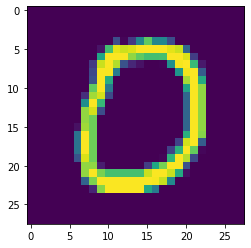

In [49]:
# i-ème image et label
i=10
X=testDataset[i][0]
y=torch.tensor(testDataset[i][1])
plt.imshow(X.squeeze().numpy())

In [66]:
#calcul V[E[y\z]]
def i_Sobol_numerateur(X,y,i,monte_num=100,p=0.5):
    model.eval()
    X=X.view(-1)
    X_expand=X.expand(monte_num,784)
    
    #calculate E[y\z_i=0]
    
    Z=torch.bernoulli(p*torch.ones(monte_num,784))
    Z[:,i]=0
    X1=X_expand*Z
    E_y_zi0=F.softmax(model(X1),dim=1).mean(dim=0)[y]
    
    #calculate E[y\z_i=1]
    Z=torch.bernoulli(p*torch.ones(monte_num,784))
    Z[:,i]=1
    X1=X_expand*Z
    E_y_zi1=F.softmax(model(X1),dim=1).mean(dim=0)[y]
    
    
    return p*(1-p)*E_y_zi0.item()**2+p*(1-p)*E_y_zi1.item()**2-2*p*(1-p)*E_y_zi1.item()*E_y_zi0.item() #
        

In [67]:
def Sobol(X,y,monte_num=100,p=0.5):
    X=X.view(-1)
    X_expand=X.expand(monte_num,784)
    
    #calculate var(y)
    Z=torch.bernoulli(p*torch.ones(monte_num,784))
    
    V_y=F.softmax(model(X_expand*Z),dim=1).var(dim=0)[y]
    
    if V_y==0:
        print("V[y]=0")
        V_y=1
    #calculate indice de sobol for each pixel
    l_res=[]
    for i in range(784):
        print("pixel:",i+1)
        l_res.append(i_Sobol_numerateur(X,y,i,monte_num,p)/V_y)
    return l_res

In [69]:
model.eval()
l_res=Sobol(X,2,monte_num=10000,p=0.5)

pixel: 1
pixel: 2
pixel: 3
pixel: 4
pixel: 5
pixel: 6
pixel: 7
pixel: 8
pixel: 9
pixel: 10
pixel: 11
pixel: 12
pixel: 13
pixel: 14
pixel: 15
pixel: 16
pixel: 17
pixel: 18
pixel: 19
pixel: 20
pixel: 21
pixel: 22
pixel: 23
pixel: 24
pixel: 25
pixel: 26
pixel: 27
pixel: 28
pixel: 29
pixel: 30
pixel: 31
pixel: 32
pixel: 33
pixel: 34
pixel: 35
pixel: 36
pixel: 37
pixel: 38
pixel: 39
pixel: 40
pixel: 41
pixel: 42
pixel: 43
pixel: 44
pixel: 45
pixel: 46
pixel: 47
pixel: 48
pixel: 49
pixel: 50
pixel: 51
pixel: 52
pixel: 53
pixel: 54
pixel: 55
pixel: 56
pixel: 57
pixel: 58
pixel: 59
pixel: 60
pixel: 61
pixel: 62
pixel: 63
pixel: 64
pixel: 65
pixel: 66
pixel: 67
pixel: 68
pixel: 69
pixel: 70
pixel: 71
pixel: 72
pixel: 73
pixel: 74
pixel: 75
pixel: 76
pixel: 77
pixel: 78
pixel: 79
pixel: 80
pixel: 81
pixel: 82
pixel: 83
pixel: 84
pixel: 85
pixel: 86
pixel: 87
pixel: 88
pixel: 89
pixel: 90
pixel: 91
pixel: 92
pixel: 93
pixel: 94
pixel: 95
pixel: 96
pixel: 97
pixel: 98
pixel: 99
pixel: 100
pixel: 1

pixel: 756
pixel: 757
pixel: 758
pixel: 759
pixel: 760
pixel: 761
pixel: 762
pixel: 763
pixel: 764
pixel: 765
pixel: 766
pixel: 767
pixel: 768
pixel: 769
pixel: 770
pixel: 771
pixel: 772
pixel: 773
pixel: 774
pixel: 775
pixel: 776
pixel: 777
pixel: 778
pixel: 779
pixel: 780
pixel: 781
pixel: 782
pixel: 783
pixel: 784


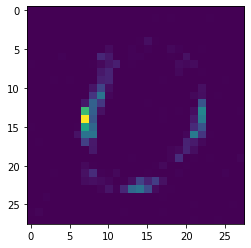

In [70]:
l_res_t=torch.tensor(l_res).view(28,28)
plt.imshow(l_res_t.squeeze().numpy())

In [71]:
model.eval()
l_res=Sobol(X,y,monte_num=10000,p=0.5)

pixel: 1
pixel: 2
pixel: 3
pixel: 4
pixel: 5
pixel: 6
pixel: 7
pixel: 8
pixel: 9
pixel: 10
pixel: 11
pixel: 12
pixel: 13
pixel: 14
pixel: 15
pixel: 16
pixel: 17
pixel: 18
pixel: 19
pixel: 20
pixel: 21
pixel: 22
pixel: 23
pixel: 24
pixel: 25
pixel: 26
pixel: 27
pixel: 28
pixel: 29
pixel: 30
pixel: 31
pixel: 32
pixel: 33
pixel: 34
pixel: 35
pixel: 36
pixel: 37
pixel: 38
pixel: 39
pixel: 40
pixel: 41
pixel: 42
pixel: 43
pixel: 44
pixel: 45
pixel: 46
pixel: 47
pixel: 48
pixel: 49
pixel: 50
pixel: 51
pixel: 52
pixel: 53
pixel: 54
pixel: 55
pixel: 56
pixel: 57
pixel: 58
pixel: 59
pixel: 60
pixel: 61
pixel: 62
pixel: 63
pixel: 64
pixel: 65
pixel: 66
pixel: 67
pixel: 68
pixel: 69
pixel: 70
pixel: 71
pixel: 72
pixel: 73
pixel: 74
pixel: 75
pixel: 76
pixel: 77
pixel: 78
pixel: 79
pixel: 80
pixel: 81
pixel: 82
pixel: 83
pixel: 84
pixel: 85
pixel: 86
pixel: 87
pixel: 88
pixel: 89
pixel: 90
pixel: 91
pixel: 92
pixel: 93
pixel: 94
pixel: 95
pixel: 96
pixel: 97
pixel: 98
pixel: 99
pixel: 100
pixel: 1

pixel: 756
pixel: 757
pixel: 758
pixel: 759
pixel: 760
pixel: 761
pixel: 762
pixel: 763
pixel: 764
pixel: 765
pixel: 766
pixel: 767
pixel: 768
pixel: 769
pixel: 770
pixel: 771
pixel: 772
pixel: 773
pixel: 774
pixel: 775
pixel: 776
pixel: 777
pixel: 778
pixel: 779
pixel: 780
pixel: 781
pixel: 782
pixel: 783
pixel: 784


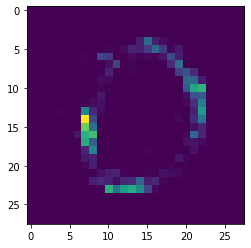

In [72]:
l_res_t=torch.tensor(l_res).view(28,28)
plt.imshow(l_res_t.squeeze().numpy())